In [1]:
from importlib import reload
import torch
from torch.nn import functional as F
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
#Import graph based
from graph_based.utils.loader import  get_dataset
from graph_based.models.gnn.layers import GraphConvolution
from graph_based.models import resnet
from graph_based.models.hyper_models import HybridGNN
from graph_based.train import train_hybrid
from graph_based.utils.evaluate import eval_normal, eval_hybrid
#Import SSL
from SSL_method import ssl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

In [2]:
def get_data_graph(nodes,links):
    dataset, _ , adj = get_dataset(nodes, links, nodes.shape[0]) 
    return dataset, adj

In [3]:
features = pd.read_csv("./graph_based/dataset/node_2label_balance.csv").to_numpy()
links = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv").to_numpy().astype(float)
links_df = pd.read_csv("./graph_based/dataset/edge_2label_balance.csv")
train_xgb = pd.read_csv("./graph_based/dataset/train.csv").to_numpy()

In [4]:
X_pool, X_gnn_test, X_xgb_pool, X_xgb_test, y_pool, y_test = train_test_split(features, train_xgb, features[:,-1],test_size=0.2, random_state= 42)
X_gnn_train, X_gnn_unlabeled, X_xgb_train, X_xgb_unlabeled, y_train, y_unlabel = train_test_split(X_pool, X_xgb_pool, y_pool, test_size=0.5, random_state= 42)


In [5]:
# dataset_train, nrm_adj_train, adjs_train = get_dataset(X_gnn_train, links, X_gnn_train.shape[0]) 
# dataset_test, nrm_adj_test, adjs_test = get_dataset(X_gnn_test, links, X_gnn_test.shape[0]) 
dataset_train, adjs_train = get_data_graph(X_gnn_train, links)
dataset_val, adj_val = get_data_graph(X_gnn_test, links)


In [6]:
nets = [resnet.ResNet(GraphConvolution,
             in_features=features.shape[1] - 2,
             cfg=[16, 16, 32, 16],
             n_residual_units=[2, 2, 2],
             hidden_layers_fc= [16,8],
             num_classes=None) for _ in range(features.shape[1] - 2)]
model_graph = HybridGNN(2, 'cuda', *nets).cuda()

c:\Users\GroooDev\anaconda3\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
pred, f1_resnet_test, acc_resnet_test, prob = eval_hybrid(model_graph, dataset_val.data, dataset_val.targets, adj_val)
print(acc_resnet_test)

0.7581098818676167


In [8]:
XGB1 = xgb.XGBClassifier(eval_metric = "logloss",objective = "binary:logistic", booster = "gbtree", tree_method = "gpu_hist",
                             max_depth = 4, gamma = 2, learning_rate = 0.005, n_estimators = 300, subsample = 0.7 , colsample_bytree = 0.7, min_child_weight = 4, use_label_encoder  = False )
evalset1 = [(X_xgb_train[:,1:-1], y_train), (X_xgb_test[:,1:-1], y_test)]
XGB1 = XGB1.fit(X_xgb_train[:,1:-1], y_train , eval_metric='logloss', eval_set=evalset1)
prediction_test1 = XGB1.predict(X_xgb_test[:,1:-1])
f1_xgb = f1_score(y_test,prediction_test1)
acc_xgb = accuracy_score(y_test,prediction_test1)

[0]	validation_0-logloss:0.69004	validation_1-logloss:0.69002
[1]	validation_0-logloss:0.68693	validation_1-logloss:0.68686
[2]	validation_0-logloss:0.68381	validation_1-logloss:0.68371
[3]	validation_0-logloss:0.68081	validation_1-logloss:0.68068
[4]	validation_0-logloss:0.67797	validation_1-logloss:0.67782
[5]	validation_0-logloss:0.67502	validation_1-logloss:0.67483
[6]	validation_0-logloss:0.67202	validation_1-logloss:0.67183
[7]	validation_0-logloss:0.66905	validation_1-logloss:0.66885
[8]	validation_0-logloss:0.66629	validation_1-logloss:0.66606
[9]	validation_0-logloss:0.66346	validation_1-logloss:0.66322
[10]	validation_0-logloss:0.66056	validation_1-logloss:0.66031
[11]	validation_0-logloss:0.65790	validation_1-logloss:0.65761
[12]	validation_0-logloss:0.65512	validation_1-logloss:0.65481
[13]	validation_0-logloss:0.65250	validation_1-logloss:0.65218
[14]	validation_0-logloss:0.64975	validation_1-logloss:0.64942
[15]	validation_0-logloss:0.64733	validation_1-logloss:0.64697
[1

In [9]:
print(f1_resnet_test, acc_resnet_test)
print(f1_xgb, acc_xgb)

0.8136376769719734 0.7581098818676167
0.8924274593064402 0.8859928745546597


In [10]:
reload(ssl)

<module 'SSL_method.ssl' from 'd:\\AI Project\\Icaller\\SSL_method\\ssl.py'>

In [11]:
model_graph.load_state_dict(torch.load("mode_new.pt", map_location='cpu'))
SSL = ssl.SSLClassifier(estimators= [XGB1,model_graph],
                    X_trains= [X_xgb_train, X_gnn_train],
                    y_train= y_train,
                    X_vals= [X_xgb_test, X_gnn_test],
                    y_val= y_test,
                    links=links,
                    p=30,
                    n=30,
                    k=80,
                    unlabeled_pool_size=500,
                    type_ssl='coal',
                    type_estimator='gb'
                    )
acc_coal1,f1_coal1,acc_coal2,f1_coal2 = SSL.fit(X_pools = [X_xgb_unlabeled, X_gnn_unlabeled],
                y_pool = y_pool)

0.8136376769719734 0.7581098818676167
1


100%|██████████| 500/500 [01:09<00:00,  7.23it/s]


0.8723975822699798 0.8584202682563339
2


100%|██████████| 500/500 [01:02<00:00,  8.04it/s]


0.8754163890739507 0.8616096207215541
3


100%|██████████| 500/500 [01:01<00:00,  8.10it/s]


0.8743516814455412 0.8620752984389348
4


100%|██████████| 500/500 [01:02<00:00,  8.02it/s]


0.8747540983606558 0.8606602225059274
5


100%|██████████| 500/500 [01:03<00:00,  7.85it/s]


0.8742416789637645 0.8610507246376812
6


100%|██████████| 500/500 [01:05<00:00,  7.63it/s]


0.8752894475686404 0.8643396905361641
7


100%|██████████| 500/500 [01:02<00:00,  7.95it/s]


0.8751638269986894 0.863831308077198
8


100%|██████████| 500/500 [01:03<00:00,  7.92it/s]


0.8739250365081941 0.8620628439552637
9


100%|██████████| 500/500 [01:03<00:00,  7.90it/s]


0.873366672043878 0.8615520282186949
10


100%|██████████| 500/500 [01:03<00:00,  7.83it/s]


0.8732574907867329 0.8614225648213034
11


100%|██████████| 500/500 [01:04<00:00,  7.79it/s]


0.8736589271417133 0.8626631853785901
12


100%|██████████| 500/500 [01:04<00:00,  7.73it/s]


0.8730659930533629 0.8609237156201349
13


100%|██████████| 500/500 [01:04<00:00,  7.76it/s]


0.872795380053067 0.8599415707166179
14


100%|██████████| 500/500 [01:05<00:00,  7.67it/s]


0.8731343283582089 0.8606795287689943
15


100%|██████████| 500/500 [01:05<00:00,  7.67it/s]


0.8715666717814946 0.8579911774686122
16


100%|██████████| 500/500 [01:05<00:00,  7.65it/s]


0.8721001221001221 0.8587084808632608
17


100%|██████████| 500/500 [01:05<00:00,  7.61it/s]


0.8754589963280295 0.8636287485340928
18


100%|██████████| 500/500 [01:08<00:00,  7.27it/s]


0.8714328627215381 0.857499583818878
19


100%|██████████| 500/500 [01:08<00:00,  7.30it/s]


0.872547551295492 0.8592224979321753
20


100%|██████████| 500/500 [01:06<00:00,  7.55it/s]


0.8707706066477867 0.8574247656635422
21


100%|██████████| 500/500 [01:06<00:00,  7.52it/s]


0.8716886192097083 0.8582870219025825


In [12]:
output = pd.read_csv("output.csv")
output['acc_coal2'] = acc_coal2

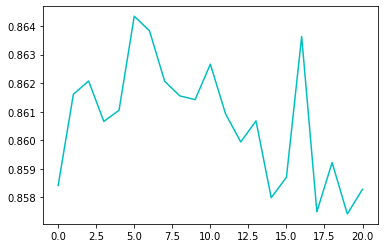

In [15]:
hnd2, = plt.plot(acc_coal2,'c',label='SSLCA')

In [16]:
output.to_excel('output.xlsx')

In [ ]:
output

,Unnamed: 0,Unnamed: 0.1,acc_co2al2,acc_al2,acc_coal2
0,0,0,0.857866,0.858804,0.860866
1,1,1,0.859179,0.859554,0.860866
2,2,2,0.861804,0.857116,0.863304
3,3,3,0.861241,0.859179,0.863866
4,4,4,0.861429,0.860116,0.862179
5,5,5,0.863116,0.860866,0.860304
6,6,6,0.861804,0.862929,0.861616
7,7,7,0.862366,0.863116,0.863116
8,8,8,0.861804,0.861241,0.862554
9,9,9,0.860866,0.861241,0.863866
